# Study Case A
This notebook will showcase an overview of the Devices and Samples models, displaying statistical summaries and distribuitions for each model. Afterwards, we will add new features in attempt to answer the proposed questions.

**Note:** Dataset snapshot used was generated on 2018-06-12.

## Questions and problem definition
**[WIP]** Define the problem and its questions

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)


# helper functions
def load_df(path, columns=None, nthreads=4, strings_to_categorical=True):
    try:
        table = pq.read_table(path, columns=columns, nthreads=nthreads)
        return table.to_pandas(strings_to_categorical=strings_to_categorical)
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    return df
        
def prepare_devices(path):
    cols = ['id', 'model', 'brand', 'manufacturer', 'product', 'os_version', 'kernel_version', 'is_root']
    return load_df(path, cols)
        
def prepare_samples(path):
    cols = ['device_id', 'timestamp', 'battery_level', 'network_status', 'screen_on', 
            'bluetooth_enabled', 'location_enabled', 'power_saver_enabled', 'nfc_enabled',
            'unknown_sources', 'developer_mode']
    
    # sorted by [device_id, timestamp]
    df = load_df(path, cols)

    df = df.reset_index(drop=True)

    df = downcast_ints(df)
    
    return df

## Acquire data
After importing the necessary libraries, we load the files into dataframes. The *samples* data was sorted beforehand by *device_id* and *timestamp*.

In [2]:
devices = prepare_devices('../src/devices.parquet')
samples = prepare_samples('../src/samples.parquet')

## Analyze by describing data
To better understand the data, we will start by looking at a sample of the data.

In [3]:
devices.sample(5)

,id,model,brand,manufacturer,product,os_version,kernel_version,is_root
218,219,sm-g930f,samsung,samsung,heroltexx,7.0,3.18.14-10422490,0
609,610,f3311,sony,sony,f3311,6.0,3.18.19+,0
2473,2474,iris 512,lava,lava,iris 512,5.1,3.10.72+,0
1914,1915,nokia_xl,nokia,nokia,rm-1030,4.1.2,3.4.0-perf,1
106,107,ale-l21,huawei,huawei,ale-l21,6.0,3.10.86-gcfbfe47-dirty,0


In [4]:
samples.sample(5)

,device_id,timestamp,battery_level,network_status,screen_on,bluetooth_enabled,location_enabled,power_saver_enabled,nfc_enabled,unknown_sources,developer_mode
2941262,2024,2017-10-17 13:43:39,83,disconnected,1,0,1,0,0,1,0
670656,370,2018-01-07 23:54:01,50,wifi,0,0,1,0,0,1,0
2133,1,2017-10-25 13:48:07,93,lte,1,0,1,0,0,0,0
844394,470,2017-10-21 09:54:32,25,wifi,0,1,1,0,0,0,0
3926833,2613,2017-11-21 09:49:57,54,wifi,1,0,0,0,0,0,0


### What are the data types for the various features?
#### Devices
- Six features are categories which represent device's specs.
- *is_root* is a boolean variable that indicates whether the device has root access.

#### Samples
- The last seven features are booleans, these are each device's settings.
- The remaining features will be useful to group the data into different subsets.

In [5]:
devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3272 entries, 0 to 3271
Data columns (total 8 columns):
id                3272 non-null uint16
model             3272 non-null category
brand             3272 non-null category
manufacturer      3272 non-null category
product           3272 non-null category
os_version        3272 non-null category
kernel_version    3272 non-null category
is_root           3272 non-null uint8
dtypes: category(6), uint16(1), uint8(1)
memory usage: 193.4 KB


In [6]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4675251 entries, 0 to 4675250
Data columns (total 11 columns):
device_id              uint16
timestamp              datetime64[ns]
battery_level          uint8
network_status         category
screen_on              uint8
bluetooth_enabled      uint8
location_enabled       uint8
power_saver_enabled    uint8
nfc_enabled            uint8
unknown_sources        uint8
developer_mode         uint8
dtypes: category(1), datetime64[ns](1), uint16(1), uint8(8)
memory usage: 84.7 MB


### What is the distribution of categorical features?

In [7]:
devices.describe(include=['category'])

,model,brand,manufacturer,product,os_version,kernel_version
count,3272,3272,3272,3272,3272,3272
unique,798,124,131,812,21,818
top,ale-l21,samsung,samsung,ale-l21,7.0,3.18.14-11104523
freq,165,1015,1010,165,1007,103


In [8]:
samples.describe(include=['category'])

,network_status
count,4675251
unique,20
top,wifi
freq,2501504


#### Inspecting *network_status* in greater detail
- We can verify that one of the most top values has label `0` which does not provide a meaningful value!

In [9]:
samples.network_status.value_counts()

wifi             2501504
disconnected     1391338
lte               442568
hspap             135349
utms               81423
0                  41947
hspa               36550
edge               22484
disconnecting      12646
hsupa               4238
hsdpa               3390
gprs                1424
connecting           100
19                    82
20                    76
evdo_a                47
30                    37
1xrtt                 30
16                    17
18                     1
Name: network_status, dtype: int64

### How many devices have samples?
Lets check what is the percentage of devices that uploaded **at least one sample**.

Defining the conversion goal, as the number of resgistered devices that upload samples, we can observe that:

The conversion is slightly below 50%, the conversion rate is not very high!

In [10]:
percentage = round(100 * samples.device_id.nunique() / devices.shape[0], 1)
print('From a population of {0} devices, {1} ' \
      'devices have samples, which represents {2}%'.format(devices.shape[0], samples.device_id.nunique(), percentage))

From a population of 3272 devices, 1609 devices have samples, which represents 49.2%


## Visualizing data
Visualizing data is crucial for recognizing underlying patterns to exploit in the model.

### How are the devices distributed according to brand and OS version?
We will plot the main features of the device's model, then we take a look at some of the samples features.

[Text(0,0.5,'# Devices')]

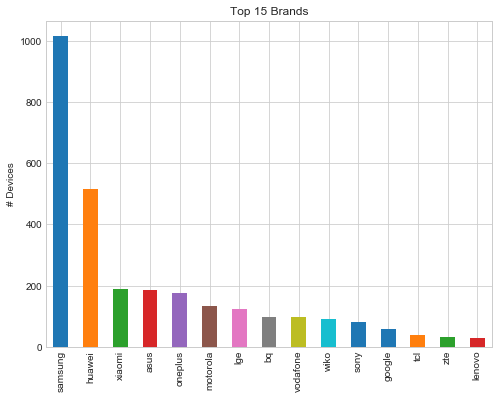

In [11]:
brands = devices.brand.value_counts()
pl = brands[0:15].plot(kind='bar', title='Top 15 Brands', figsize=figsize)
pl.set(ylabel='# Devices')

[Text(0,0.5,'# Devices')]

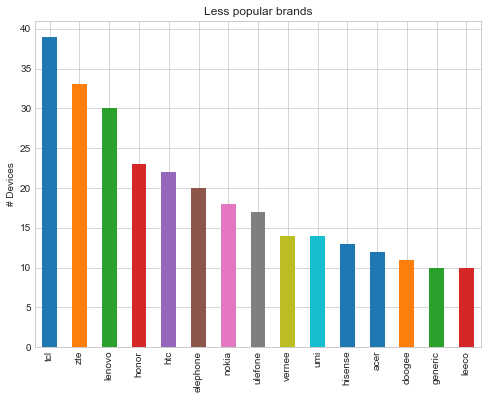

In [12]:
pl = brands[brands.between(10, 50)].plot(kind='bar', title='Less popular brands', figsize=figsize)
pl.set(ylabel='# Devices')

[Text(0,0.5,'# Devices')]

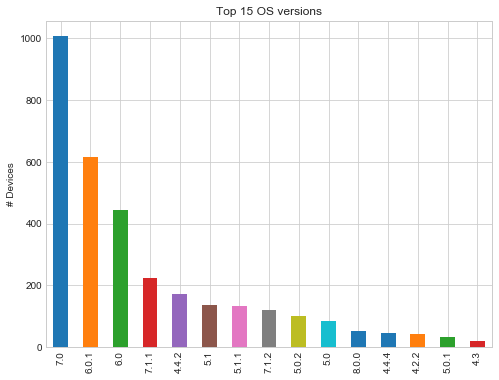

In [13]:
versions = devices.os_version.value_counts()
pl = versions[:15].plot(kind='bar', title='Top 15 OS versions', figsize=figsize)
pl.set(ylabel='# Devices')

[Text(0,0.5,'# Devices')]

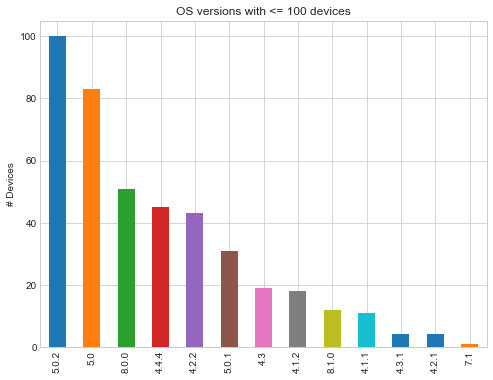

In [14]:
pl = versions[versions <= 100].plot(kind='bar', title='OS versions with <= 100 devices', figsize=figsize)
pl.set(ylabel='# Devices')

2958 devices do not have root access, while 314 devices are rooted


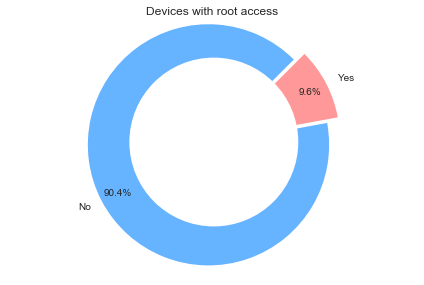

In [15]:
def plot_pie(data, title, labels,
                 colors=['#66b3ff','#ff9999','#99ff99','#ffcc99'], explode=(0.05, 0.05, 0.05, 0.05)):
    fig1, ax1 = plt.subplots()

    ax1.pie(data, colors=colors, labels=labels,
            autopct='%1.1f%%', startangle=45, pctdistance=0.85, explode=explode)

    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    fig.suptitle(title)

    ax1.axis('equal')  
    plt.tight_layout()
    
rooted = devices.is_root.value_counts()
plot_pie(rooted, 'Devices with root access', ['No', 'Yes'], ['#66b3ff','#ff9999'], (0.05, 0.05))

print('{0} devices do not have root access, while {1} devices are rooted' \
      .format(rooted[0], rooted[1]))

[Text(0,0.5,'# Samples')]

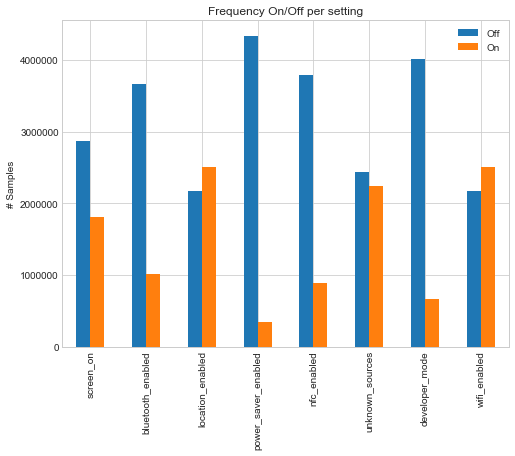

In [16]:
settings = ['screen_on', 'bluetooth_enabled', 'location_enabled', 'power_saver_enabled', 
            'nfc_enabled', 'unknown_sources', 'developer_mode', 'wifi_enabled']

# Add new setting
samples['wifi_enabled'] = (samples['network_status'] == 'wifi').astype(np.uint8)

# Frequency on/off per setting
freqs = samples[settings].apply(pd.value_counts, axis=0).T
freqs.columns = ['Off', 'On']
pl = freqs.plot(kind='bar', title='Frequency On/Off per setting', figsize=figsize)
pl.set(ylabel='# Samples')

### How are devices distributed by conversion rates?

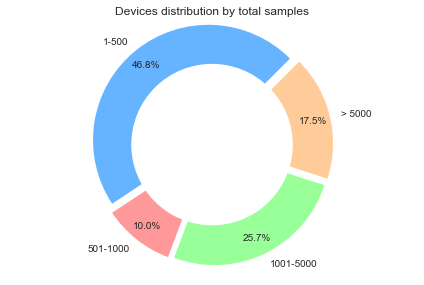

In [17]:
def calculate_blocks(df):
    blocks = pd.DataFrame(df)
    total = blocks.shape[0]
    blocks = blocks[0]
    return [
        blocks[blocks.between(1, 500)].count(),
        blocks[blocks.between(501, 1000)].count(),
        blocks[blocks.between(1001, 5000)].count(),
        blocks[blocks > 5000].count()
    ]

blocks = calculate_blocks(samples.groupby('device_id').size())
plot_pie(blocks, 'Devices distribution by total samples', ['1-500', '501-1000', '1001-5000', '> 5000'])

#### Additionally, we can take a look at the high volume samples results:

In [18]:
def calculate_conversion(limit):
    df = pd.DataFrame(samples.groupby('device_id').size() > limit, columns=['goal'])
    num = df[df.goal].shape[0]
    percentage = round(100 * num / devices.shape[0], 1)
    print('{0:<3} devices have more than {1} samples, that represents {2}%'.format(num, limit, percentage))

calculate_conversion(10000)
calculate_conversion(25000)

123 devices have more than 10000 samples, that represents 3.8%
25  devices have more than 25000 samples, that represents 0.8%


## Transforming Features
1. First, add a new feature *wifi_enabled* (done in the previous step), will tell us if a sample has `wifi` value or some other status. This will be necessary to calculate another feature.
2. Next, calculate the changes over time and battery level, *time_diff* will be the time passed between each sample and *pct_change* the change percentage compared with the previous sample. The latter can be specially useful to group samples in batches of battery levels.
3. We will also add an extra feature *discharging* (`1.0` for discharge state, `0.0` for charge state) which will make it easier to group samples by battery state.
4. Combine the settings values into a numeric class, obtained by converting the group of values into a decimal number.
5. Lastly, drop useless features. We can drop the settings features since we have the *combination* value.

In [19]:
samples['time_diff'] = samples.timestamp.diff()
samples.loc[samples.device_id != samples.device_id.shift(), 'time_diff'] = None

samples['change'] = samples.battery_level.pct_change().round(2)
samples.loc[samples.device_id != samples.device_id.shift(), 'change'] = None

samples['discharging'] = samples.battery_level.shift() >= samples.battery_level
samples.loc[samples.device_id != samples.device_id.shift(), 'discharging'] = None

samples['combination'] = np.packbits(samples[settings].values, axis=-1)

samples = samples.drop(settings, axis=1)

samples.sample(5)

,device_id,timestamp,battery_level,network_status,time_diff,change,discharging,combination
2592753,1765,2018-03-26 19:31:32,1,wifi,00:00:10,0.00,1.0,145
3624726,2409,2017-10-24 16:29:22,63,wifi,00:01:06,0.02,0.0,33
3155111,2152,2017-11-01 23:12:42,36,disconnected,00:08:01,-0.03,1.0,152
1582122,1065,2017-10-27 00:32:56,53,wifi,00:01:08,0.02,0.0,5
3831041,2528,2017-12-11 21:30:37,42,lte,00:00:39,0.02,0.0,72


[Text(0,0.5,'# Samples'), Text(0.5,0,'Combinations')]

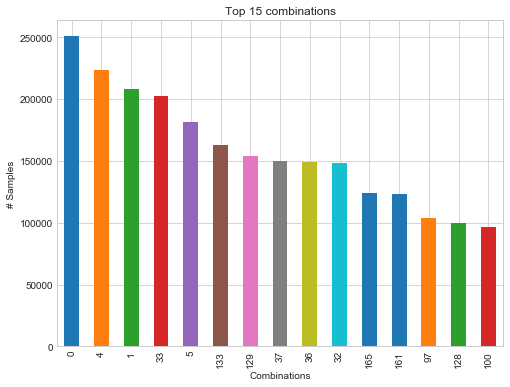

In [20]:
combs = samples.combination.value_counts().T
pl = combs[0:15].plot(kind='bar', title='Top 15 combinations', figsize=figsize)
pl.set(xlabel='Combinations', ylabel='# Samples')

### How many samples of each type overall and by device?
Next, we will group the samples by Device and count the samples of each state charging and discharging.
We can also calculate how many devices have each type of sample or even both. We use the *discharging* feature to group them.

The number of samples will differ **according to the sample type filter criteria!**

2365315 are charging samples, while 2308327 are discharging samples


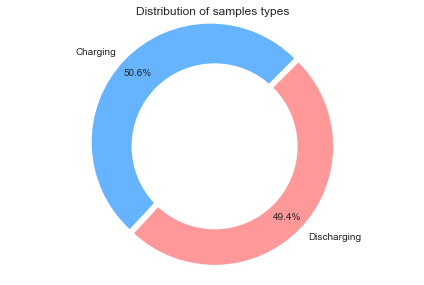

In [21]:
types = samples.discharging.value_counts()

plot_pie(types, 'Distribution of samples types', ['Charging', 'Discharging'],
         ['#66b3ff','#ff9999'], (0.05,0))

print('{0} are charging samples, while {1} are discharging samples' \
      .format(types[0], types[1]))

In [22]:
stypes = samples.groupby('device_id').discharging.value_counts().unstack().fillna(0)
stypes.columns = ['charging', 'discharging']
stypes = stypes.astype(np.int)
stypes = downcast_ints(stypes)

stypes.sample(5)

,charging,discharging
device_id,,
2453,88,515
315,1593,1998
176,244,205
2243,153,272
903,367,85


In [23]:
both = stypes[(stypes.charging > 0) & (stypes.discharging > 0)].shape[0]
c_only = stypes[(stypes.charging > 0) & (stypes.discharging == 0)].shape[0]
d_only = stypes[(stypes.charging == 0) & (stypes.discharging > 0)].shape[0]

print('{0} devices have both types of samples, {1} only charging ' \
      'samples and {2} just discharging samples.'.format(both, c_only, d_only))

print('From all {0} unique devices, {1} are counted ' \
      'according to the filter criteria.' \
      .format(samples.device_id.unique().shape[0], stypes.index.unique().shape[0]))

1382 devices have both types of samples, 15 only charging samples and 89 just discharging samples.
From all 1609 unique devices, 1486 are counted according to the filter criteria.


### What is the distribution of samples with consecutive battery levels?
- Lets try to split the samples in batches of consecutive battery level values, to better understand, what is an average session of usage for a device.
- We will start by selecting only the samples with a **1%** change maximum.

In [24]:
change_interval = samples.change.between(-0.01, 0.01)

seqs = samples[change_interval].copy()

seqs['consecutive'] = abs(seqs.battery_level.shift() - seqs.battery_level) <= 1
seqs.loc[seqs.device_id != seqs.device_id.shift(), 'consecutive'] = False
seqs.loc[seqs.discharging != seqs.discharging.shift(), 'consecutive'] = False

def batch_len(s):
    return s * (s.groupby((s != s.shift()).cumsum()).cumcount() + 1)

seqs['batch'] = batch_len(seqs.consecutive)

seqs.shape[0]

2032035